In [7]:
pip install scipy


Note: you may need to restart the kernel to use updated packages.


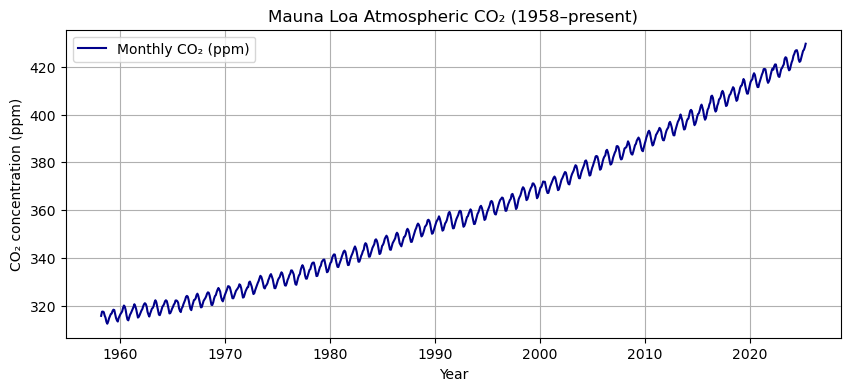

Train set: 644 samples
 Test set: 162 samples


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch

# ─── 1) Load the Mauna Loa CO₂ dataset, using the first non-comment line as header ─────
file_path = r"C:\Users\lemai\Documents\Cours\M2\ASI\Projet\co2_mm_mlo.csv"
# comment='#' skips lines beginning with '#'; header=0 makes pandas use the first non-comment as column names
df_raw = pd.read_csv(file_path, comment='#', header=0)

# Rename the “decimal date” column to a Python-friendly name
df_raw.rename(columns={'decimal date': 'decimal_date'}, inplace=True)

# ─── 2) Drop missing values ───────────────────────────────────────────────────────────
# NOAA marks missing monthly CO₂ as –99.99 in the “average” column
df = df_raw[df_raw['average'] != -99.99].copy()

# ─── 3) Prepare X and y ──────────────────────────────────────────────────────────────
# We’ll predict “average” from “decimal_date”
X = df[['decimal_date']].values    # shape (N, 1), float
y = df[['average']].values         # shape (N, 1), float

# ─── 4) Visualize the raw data ───────────────────────────────────────────────────────
plt.figure(figsize=(10, 4))
plt.plot(df['decimal_date'], df['average'], color='darkblue', label='Monthly CO₂ (ppm)')
plt.xlabel('Year')
plt.ylabel('CO₂ concentration (ppm)')
plt.title('Mauna Loa Atmospheric CO₂ (1958–present)')
plt.legend()
plt.grid(True)
plt.show()

# ─── 5) Standardize features and target ───────────────────────────────────────────────
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)   # (N,1) array of floats
y_scaled = scaler_y.fit_transform(y)   # (N,1) array of floats

# ─── 6) Split into train/test (80% train, 20% test) ─────────────────────────────────
n = X_scaled.shape[0]
split_idx = int(0.8 * n)

X_train = X_scaled[:split_idx]
X_test  = X_scaled[split_idx:]
y_train = y_scaled[:split_idx]
y_test  = y_scaled[split_idx:]

# ─── 7) Convert to PyTorch tensors ────────────────────────────────────────────────
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_test_tensor  = torch.from_numpy(X_test).float()
y_test_tensor  = torch.from_numpy(y_test).float()

print(f"Train set: {X_train_tensor.shape[0]} samples")
print(f" Test set: {X_test_tensor.shape[0]} samples")


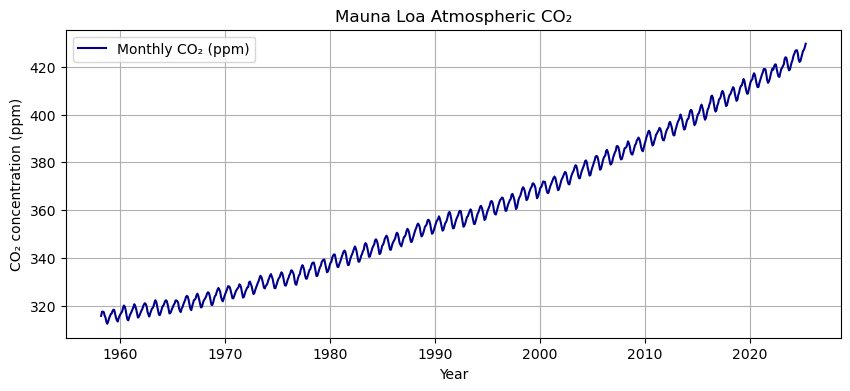

Epoch 50/200  Loss: 0.0200
Epoch 100/200  Loss: 0.0164
Epoch 150/200  Loss: 0.0149
Epoch 200/200  Loss: 0.0166


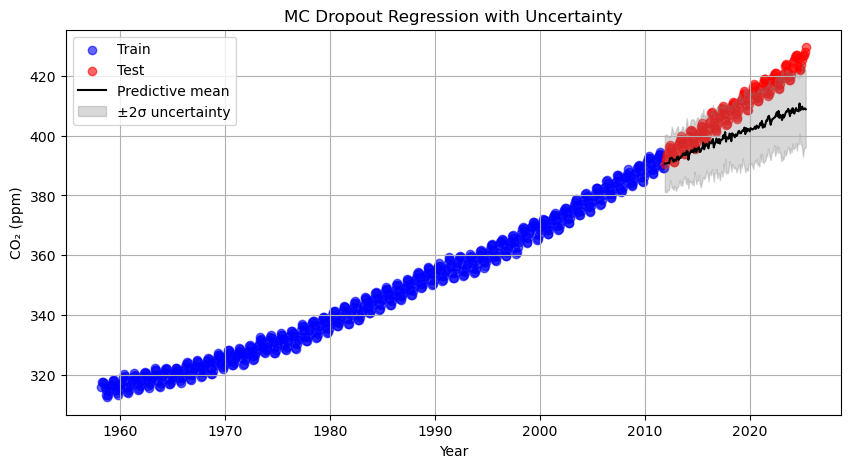

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F

# ─── 1) Load and clean the Mauna Loa CO₂ data ────────────────────────────────
file_path = r"C:\Users\lemai\Documents\Cours\M2\ASI\Projet\co2_mm_mlo.csv"
df = pd.read_csv(file_path, comment='#', header=0)
df.rename(columns={'decimal date': 'decimal_date'}, inplace=True)
df = df[df['average'] != -99.99].copy()

# ─── 2) Prepare X and y ─────────────────────────────────────────────────────────
X = df[['decimal_date']].values.astype(float)  # (N,1)
y = df[['average']].values.astype(float)       # (N,1)

# ─── 3) Visualize raw data ──────────────────────────────────────────────────────
plt.figure(figsize=(10,4))
plt.plot(df['decimal_date'], df['average'], color='darkblue', label='Monthly CO₂ (ppm)')
plt.xlabel('Year'); plt.ylabel('CO₂ concentration (ppm)')
plt.title('Mauna Loa Atmospheric CO₂'); plt.grid(True); plt.legend()
plt.show()

# ─── 4) Standardize features and target ─────────────────────────────────────────
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# ─── 5) Train/test split (80% / 20%) ────────────────────────────────────────────
n = X_scaled.shape[0]
split = int(0.8 * n)
X_train, X_test = X_scaled[:split], X_scaled[split:]
y_train, y_test = y_scaled[:split], y_scaled[split:]

# Convert to PyTorch tensors
X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train).float()
X_test_t  = torch.from_numpy(X_test).float()
y_test_t  = torch.from_numpy(y_test).float()

# ─── 6) Define the MC Dropout network ───────────────────────────────────────────
class MCDropoutNet(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=50, dropout_p=0.1):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.drop1 = nn.Dropout(p=dropout_p)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.drop2 = nn.Dropout(p=dropout_p)
        self.out = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        # Always apply dropout, even at test time
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        return self.out(x)

model = MCDropoutNet(dropout_p=0.1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# ─── 7) Training loop ───────────────────────────────────────────────────────────
model.train()
epochs = 200
for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    y_pred = model(X_train_t)
    loss = criterion(y_pred, y_train_t)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}/{epochs}  Loss: {loss.item():.4f}")

# ─── 8) MC Dropout inference ────────────────────────────────────────────────────
model.train()  # ensure dropout is active
T = 50         # number of stochastic forward passes
preds = []
with torch.no_grad():
    for _ in range(T):
        preds.append(model(X_test_t).cpu().numpy().squeeze())
preds = np.array(preds)           # shape (T, N_test)
mean_pred = preds.mean(axis=0)    # predictive mean (scaled)
std_pred  = preds.std(axis=0)     # predictive std (scaled)

# Un-scale back to original ppm
X_test_orig  = scaler_X.inverse_transform(X_test)
y_test_orig  = scaler_y.inverse_transform(y_test)
y_mean_orig  = scaler_y.inverse_transform(mean_pred.reshape(-1,1)).squeeze()
y_std_orig   = std_pred * scaler_y.scale_[0]

# ─── 9) Plot predictions + uncertainty ──────────────────────────────────────────
plt.figure(figsize=(10,5))
# training points
plt.scatter(scaler_X.inverse_transform(X_train), scaler_y.inverse_transform(y_train),
            color='blue', alpha=0.6, label='Train')
# test points
plt.scatter(X_test_orig, y_test_orig, color='red', alpha=0.6, label='Test')
# predictive mean
plt.plot(X_test_orig, y_mean_orig, color='black', label='Predictive mean')
# uncertainty band ±2σ
plt.fill_between(X_test_orig.squeeze(),
                 y_mean_orig - 2*y_std_orig,
                 y_mean_orig + 2*y_std_orig,
                 color='gray', alpha=0.3, label='±2σ uncertainty')
plt.xlabel('Year'); plt.ylabel('CO₂ (ppm)')
plt.title('MC Dropout Regression with Uncertainty')
plt.legend(); plt.grid(True)
plt.show()

In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import fetch_openml
from sklearn.datasets._openml import OpenMLError
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import TensorDataset, DataLoader

# ─── Hyperparameters ─────────────────────────────────────────────────────
EPOCHS     = 200
MC_RUNS    = 20
BATCH_SIZE = 64

# ─── GPU device ───────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─── Path to Naval dataset ────────────────────────────────────────────────
NAVAL_PATH = r"C:\Users\lemai\Documents\Cours\M2\ASI\Projet\condition+based+maintenance+of+naval+propulsion+plants\UCI CBM Dataset\data.txt"

def load_uci(name):
    """
    Charge les datasets UCI (Boston, Concrete, Kin8nm, Yacht, Naval) 
    et Energy efficiency (Excel) directement depuis le site UCI.
    """
    if name == "Naval Propulsion Plants":
        df = pd.read_csv(NAVAL_PATH, delim_whitespace=True, header=None)
        arr = df.values.astype(np.float32)
        X, y = arr[:, :-1], arr[:, -1:].reshape(-1, 1)

    elif name == "Yacht Hydrodynamics":
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data"
        df = pd.read_csv(url, delim_whitespace=True, header=None)
        arr = df.values.astype(np.float32)
        X, y = arr[:, :-1], arr[:, -1:].reshape(-1, 1)

    elif name == "Energy efficiency":
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
        df = pd.read_excel(url)
        arr = df.values.astype(np.float32)
        X = arr[:, :8]
        y = arr[:, 8].reshape(-1, 1)                    # target Y1 (heating load)
    
    else:
        id_map = {
            "Boston": 531,
            "Concrete": 1471,
            "kin8nm": 189
        }
        did = id_map.get(name)
        if did is None:
            raise ValueError(f"Dataset {name} not recognized.")
        try:
            ds = fetch_openml(data_id=did, as_frame=False)
        except OpenMLError:
            ds = fetch_openml(name=name, version=1, as_frame=False)
        X = ds.data.astype(np.float32)
        y = ds.target.astype(np.float32).reshape(-1, 1)

    return X, y

# ─── Model ───────────────────────────────────────────────────────────────
class Net(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_p=0.05):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 50)
        self.fc2 = nn.Linear(50, 50)
        self.out = nn.Linear(50, output_dim)
        self.dropout_p = dropout_p

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        return self.out(x)

# ─── Training loop ───────────────────────────────────────────────────────
def train(model, loader, loss_fn, optimizer, epochs=EPOCHS):
    model.train()
    for epoch in range(1, epochs+1):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 50 == 0:
            print(f"  Epoch {epoch}/{epochs} – loss: {loss.item():.4f}")

# ─── Evaluation ─────────────────────────────────────────────────────────
def evaluate(model, X_te, y_te, mc_runs=MC_RUNS, use_mc=False):
    if use_mc:
        model.train()
    else:
        model.eval()

    X_tensor = torch.from_numpy(X_te).float().to(device)
    all_preds = []
    with torch.no_grad():
        for _ in range(mc_runs if use_mc else 1):
            out = model(X_tensor).cpu().numpy()  # (n_samples, 1)
            all_preds.append(out)

    preds = np.stack(all_preds, axis=0)      # (runs, n_samples, 1)
    preds = preds[:, :, 0]                   # (runs, n_samples)
    mean_pred = preds.mean(axis=0)           # (n_samples,)
    true      = y_te.reshape(-1)
    rmse      = np.sqrt(mean_squared_error(true, mean_pred))
    return rmse

# ─── Experiment ─────────────────────────────────────────────────────────
def run_experiment(name, dropout_p=0.05, test_size=0.2, seeds=range(2)):
    results = {"no_mc": [], "mc": []}
    for seed in seeds:
        np.random.seed(seed)
        torch.manual_seed(seed)

        X, y = load_uci(name)
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=test_size, random_state=seed)
        sx, sy = StandardScaler().fit(X_tr), StandardScaler().fit(y_tr)
        X_tr_s, X_te_s = sx.transform(X_tr), sx.transform(X_te)
        y_tr_s, y_te_s = sy.transform(y_tr), sy.transform(y_te)

        ds     = TensorDataset(torch.from_numpy(X_tr_s).float(),
                               torch.from_numpy(y_tr_s).float())
        loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True,
                            num_workers=4, pin_memory=True)

        model    = Net(input_dim=X.shape[1], output_dim=1, dropout_p=dropout_p).to(device)
        optimizer= torch.optim.Adam(model.parameters(), lr=1e-3)
        loss_fn  = nn.MSELoss()

        train(model, loader, loss_fn, optimizer)
        results["no_mc"].append(evaluate(model, X_te_s, y_te_s, use_mc=False))
        results["mc"].append(   evaluate(model, X_te_s, y_te_s, use_mc=True))

    return results

# ─── Main ───────────────────────────────────────────────────────────────
if __name__ == "__main__":
    datasets = [
        "Boston",
        "Concrete",
        "Energy efficiency",
        "kin8nm",
        "Yacht Hydrodynamics",
        "Naval Propulsion Plants"
    ]
    for ds in datasets:
        print(f"\n>>> Dataset: {ds} (dropout=0.05, epochs={EPOCHS}) <<<")
        res   = run_experiment(ds)
        no_mc = np.array(res["no_mc"])
        mc    = np.array(res["mc"])
        print(f"No MC dropout – RMSE = {no_mc.mean():.3f} ± {no_mc.std():.3f}")
        print(f"MC dropout    – RMSE = {mc.mean():.3f} ± {mc.std():.3f}")



>>> Dataset: Boston (dropout=0.05, epochs=200) <<<


C:\Users\lemai\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
C:\Users\lemai\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Epoch 50/200 – loss: 0.1434
  Epoch 100/200 – loss: 0.0698
  Epoch 150/200 – loss: 0.0465
  Epoch 200/200 – loss: 0.0359


C:\Users\lemai\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
C:\Users\lemai\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Epoch 50/200 – loss: 0.1522
  Epoch 100/200 – loss: 0.0993
  Epoch 150/200 – loss: 0.0293
  Epoch 200/200 – loss: 0.0419
No MC dropout – RMSE = 0.346 ± 0.085
MC dropout    – RMSE = 0.347 ± 0.082

>>> Dataset: Concrete (dropout=0.05, epochs=200) <<<


C:\Users\lemai\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
C:\Users\lemai\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Epoch 50/200 – loss: 0.8724
  Epoch 100/200 – loss: 0.2448
  Epoch 150/200 – loss: 0.1261
  Epoch 200/200 – loss: 0.2189


C:\Users\lemai\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
C:\Users\lemai\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Epoch 50/200 – loss: 0.2560
  Epoch 100/200 – loss: 0.3439
  Epoch 150/200 – loss: 0.0914
  Epoch 200/200 – loss: 0.4449
No MC dropout – RMSE = 122.882 ± 75.882
MC dropout    – RMSE = 95.601 ± 45.372

>>> Dataset: Energy efficiency (dropout=0.05, epochs=200) <<<


C:\Users\lemai\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Epoch 50/200 – loss: 0.0482
  Epoch 100/200 – loss: 0.0414
  Epoch 150/200 – loss: 0.0159
  Epoch 200/200 – loss: 0.0163


C:\Users\lemai\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Epoch 50/200 – loss: 0.0511
  Epoch 100/200 – loss: 0.0320
  Epoch 150/200 – loss: 0.0154
  Epoch 200/200 – loss: 0.0096
No MC dropout – RMSE = 0.073 ± 0.005
MC dropout    – RMSE = 0.080 ± 0.007

>>> Dataset: kin8nm (dropout=0.05, epochs=200) <<<


C:\Users\lemai\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
C:\Users\lemai\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Epoch 50/200 – loss: 0.1907
  Epoch 100/200 – loss: 0.0559
  Epoch 150/200 – loss: 0.0639
  Epoch 200/200 – loss: 0.1262


C:\Users\lemai\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
C:\Users\lemai\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Epoch 50/200 – loss: 0.0740
  Epoch 100/200 – loss: 0.0775
  Epoch 150/200 – loss: 0.0361
  Epoch 200/200 – loss: 0.0423
No MC dropout – RMSE = 0.275 ± 0.010
MC dropout    – RMSE = 0.277 ± 0.010

>>> Dataset: Yacht Hydrodynamics (dropout=0.05, epochs=200) <<<


C:\Users\lemai\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Epoch 50/200 – loss: 0.0937
  Epoch 100/200 – loss: 0.0154
  Epoch 150/200 – loss: 0.0237
  Epoch 200/200 – loss: 0.0127


C:\Users\lemai\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Epoch 50/200 – loss: 0.0539
  Epoch 100/200 – loss: 0.0193
  Epoch 150/200 – loss: 0.0168
  Epoch 200/200 – loss: 0.0088
No MC dropout – RMSE = 0.104 ± 0.003
MC dropout    – RMSE = 0.104 ± 0.012

>>> Dataset: Naval Propulsion Plants (dropout=0.05, epochs=200) <<<


C:\Users\lemai\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Epoch 50/200 – loss: 0.2539
  Epoch 100/200 – loss: 0.0613
  Epoch 150/200 – loss: 0.0282
  Epoch 200/200 – loss: 0.0455


C:\Users\lemai\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Epoch 50/200 – loss: 0.0987
  Epoch 100/200 – loss: 0.0588
  Epoch 150/200 – loss: 0.0393
  Epoch 200/200 – loss: 0.0231
No MC dropout – RMSE = 0.120 ± 0.024
MC dropout    – RMSE = 0.124 ± 0.024


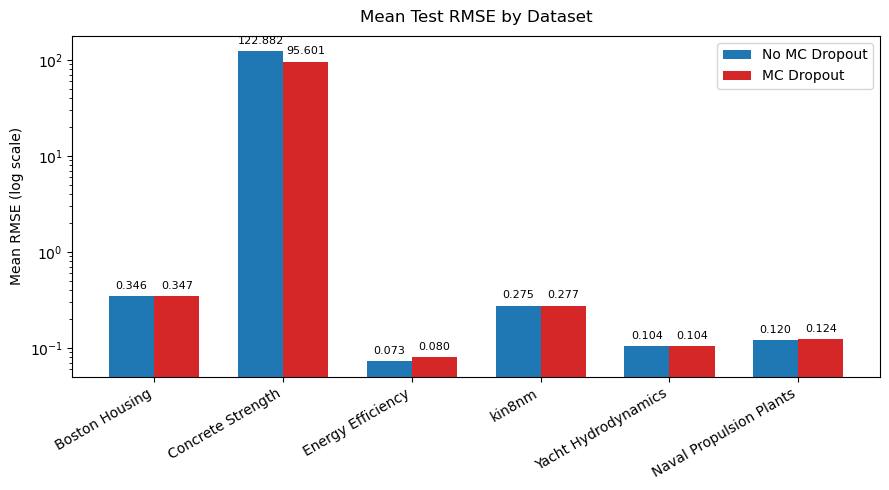

In [3]:
import numpy as np
import matplotlib.pyplot as plt

datasets = [
    "Boston Housing",
    "Concrete Strength",
    "Energy Efficiency",
    "kin8nm",
    "Yacht Hydrodynamics",
    "Naval Propulsion Plants"
]
no_mc = np.array([0.346, 122.882, 0.073, 0.275, 0.104, 0.120])
mc    = np.array([0.347,  95.601, 0.080, 0.277, 0.104, 0.124])

x     = np.arange(len(datasets))
width = 0.35

fig, ax = plt.subplots(figsize=(9, 5))

bars1 = ax.bar(x - width/2, no_mc, width, label='No MC Dropout', color='C0')
bars2 = ax.bar(x + width/2, mc,    width, label='MC Dropout',    color='C3')


ax.set_yscale('log')

ax.set_title("Mean Test RMSE by Dataset", pad=10)
ax.set_ylabel("Mean RMSE (log scale)")
ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=30, ha='right')
ax.legend()

for bars in (bars1, bars2):
    for bar in bars:
        h = bar.get_height()
        ax.annotate(f"{h:.3f}",
                    xy=(bar.get_x() + bar.get_width()/2, h),
                    xytext=(0, 4),          
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8)

plt.tight_layout()
plt.show()
